# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_3227/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import glob,imp,os,shutil
/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_3227/1200496628.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


#### Create txname/process translator

In [2]:
processDict = {'TRV1tt' : r'$p p \to \bar{t} t$',
               'TRV1jj' : r'$p p \to j j$',
               'TRV1bb' : r'$p p \to \bar{b} b$',
               'TRV1qq' : r'$p p \to \bar{q} q$',
               'TRV1' : r'$p p \to \chi \chi$',
               'TRS1' : r'$p p \to \chi \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel

#### Get data in pcl format

In [3]:
#Merge with SModelS DataFrame
pclFiles = ['./smodels_results_slha_100k_pts.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900032', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'mass.9900026', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.chi,chi', 'BRs.sd.higgs,higgs', 'BRs.sd.W-,W+', 'BRs.sd.Z,Z', 'BRs.zp.chi,chi', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.sd.t-,t+', 'BRs.sd.ta+,ta-', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 99999
Total excluded (LHC) = 36703
Total allowed = 63296



### Get all exclusion curves

In [7]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID']


In [8]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [9]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [10]:
txnames.append(['TRS1', 'TRV1'])

In [11]:
txnames

['TRV1', 'TRS1', 'TRV1jj', 'TRV1bb', 'TRV1qq', 'TRV1tt', ['TRS1', 'TRV1']]

In [12]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [13]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [14]:
newDF[['ExptRes.result.AnalysisID','ExptRes.result.TxNames','ExptRes.result.r']]

ExptRes.result.AnalysisID ExptRes.result.TxNames  ExptRes.result.r
0                 CMS-EXO-20-004                 [TRV1]        135.283000
1                 CMS-EXO-20-004                 [TRV1]        133.953000
2                 CMS-EXO-20-004                 [TRV1]        132.254500
3                 CMS-EXO-20-004                 [TRV1]        127.658100
4                 CMS-EXO-20-004                 [TRV1]        125.340100
...                          ...                    ...               ...
342254            CMS-EXO-19-012               [TRV1jj]          0.000041
342255            CMS-EXO-20-004                 [TRV1]          0.000021
342256            CMS-EXO-20-004                 [TRV1]          0.000015
342257            CMS-EXO-20-004                 [TRV1]          0.000015
342258            CMS-EXO-20-004                 [TRV1]         -1.000000

[342259 rows x 3 columns]

In [15]:
newDF['excluded'] = newDF['ExptRes.result.r'] > 1.0
excluded = newDF[newDF['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels

In [16]:
newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')
excluded = excluded.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')

In [17]:
excluded['label'].unique()

array(['CMS-EXO-20-004 (TRV1)', 'CMS-EXO-16-057 (TRV1bb)',
       'ATLAS-EXOT-2019-03 (TRV1jj)', 'ATLAS-EXOT-2018-48 (TRV1tt)',
       'CMS-EXO-19-012 (TRV1jj)', 'CMS-EXO-20-008 (TRV1bb)',
       'ATLAS-EXOT-2013-11 (TRV1qq)', 'CMS-EXO-12-059 (TRV1qq)'],
      dtype=object)

In [18]:
# sqrt13 = ['CMS-EXO-20-004', 'CMS-EXO-20-008', 'CMS-PAS-EXO-20-008', 'ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2018-48',
#           'CMS-EXO-19-012']
# sqrt8 = ['CMS-EXO-16-057', 'CMS-EXO-12-059']

In [19]:
# for index, row in excluded.iterrows():
#     for a in sqrt13:
#         if a in row['label']:
#             ana = row['label']
#             excluded['label'][index] = row['label']+' (13 TeV)'
#     for a in sqrt8:
#         if a in row['label']:
#             ana = row['label']
#             excluded['label'][index] = row['label']+' (8 TeV)'
    

In [20]:
# for index, row in newDF.iterrows():
#     for a in sqrt13:
#         if a in row['label']:
#             ana = row['label']
#             newDF['label'][index] = row['label']+' (13 TeV)'
#     for a in sqrt8:
#         if a in row['label']:
#             ana = row['label']
#             newDF['label'][index] = row['label']+' (8 TeV)'
    

In [21]:
# newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRV1)', value='CMS-EXO-20-004 (TRV1,TRS1)')
# excluded = excluded.replace(to_replace='CMS-EXO-20-004 (TRV1)', value='CMS-EXO-20-004 (TRV1,TRS1)')

In [22]:
colors = sns.color_palette("Set1",len(excluded['label'].unique()))


In [23]:
colorDict = {}

for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)

In [24]:
colorDict

{'CMS-EXO-20-004 (TRV1)': array([[0.89411765, 0.10196078, 0.10980392]]),
 'CMS-EXO-16-057 (TRV1bb)': array([[0.21568627, 0.49411765, 0.72156863]]),
 'ATLAS-EXOT-2019-03 (TRV1jj)': array([[0.30196078, 0.68627451, 0.29019608]]),
 'ATLAS-EXOT-2018-48 (TRV1tt)': array([[0.59607843, 0.30588235, 0.63921569]]),
 'CMS-EXO-19-012 (TRV1jj)': array([[1.        , 0.49803922, 0.        ]]),
 'CMS-EXO-20-008 (TRV1bb)': array([[1. , 1. , 0.2]]),
 'ATLAS-EXOT-2013-11 (TRV1qq)': array([[0.65098039, 0.3372549 , 0.15686275]]),
 'CMS-EXO-12-059 (TRV1qq)': array([[0.96862745, 0.50588235, 0.74901961]])}

In [25]:
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=convertLabel(ana))
    legend.append(l)

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_3227/3227815988.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu_r')


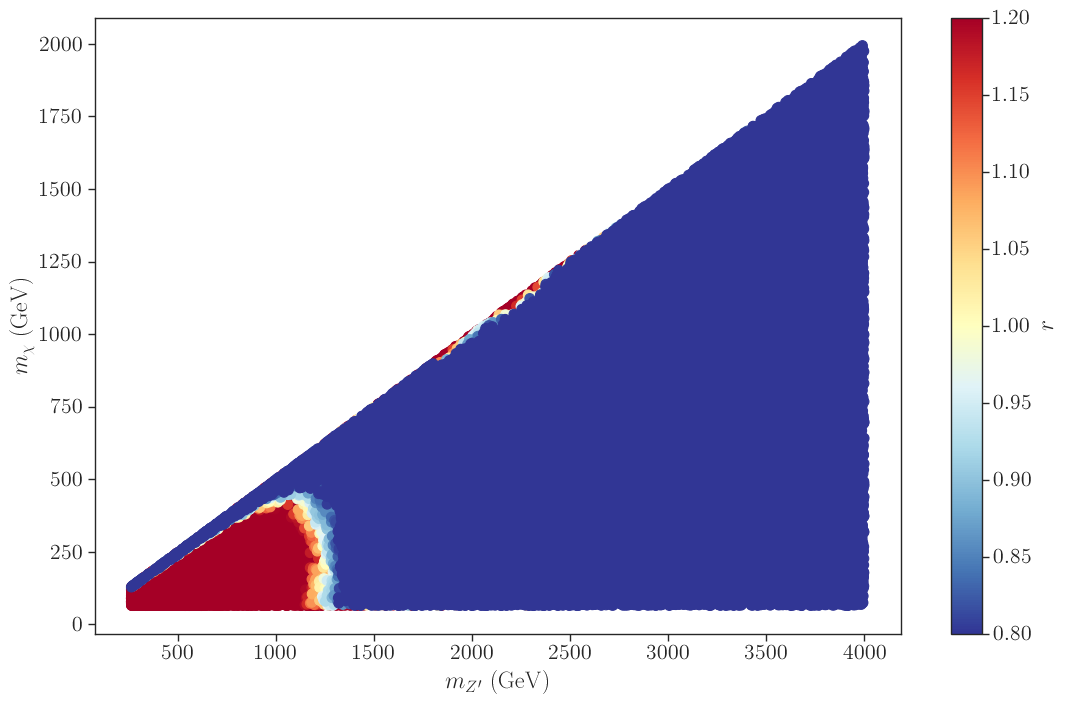

In [26]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))


x = dataDF['mass.9900032']
y = dataDF['mass.9000006']
c = dataDF['ExptRes.result0.r']

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
# plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
#          transform = plt.gca().transAxes)

# plt.legend()
plt.show()

In [27]:
dataDF['extpar.1'].unique()

array([4.5     , 3.      , 2.5     , 1.8     , 1.414214])

In [28]:
dataDF['extpar.2'].unique()

array([0.25 , 0.2  , 0.15 , 0.125, 0.1  ])

In [29]:
newDF['label'].unique()

array(['CMS-EXO-20-004 (TRV1)', 'CMS-EXO-16-057 (TRV1bb)',
       'ATLAS-EXOT-2019-03 (TRV1jj)', 'ATLAS-EXOT-2013-11 (TRV1qq)',
       'CMS-EXO-12-059 (TRV1qq)', 'ATLAS-EXOT-2018-48 (TRV1tt)',
       'CMS-EXO-19-012 (TRV1jj)', 'CMS-EXO-20-008 (TRV1bb)',
       'CMS-EXO-20-004 (TRS1)'], dtype=object)

In [30]:
len(dataDF[(dataDF['extpar.2']==0.25)&(dataDF['extpar.1']==1.8)])

4084

In [31]:
# newDF = newDF.loc[newDF['label'] != 'CMS-EXO-20-004 (TRS1)']

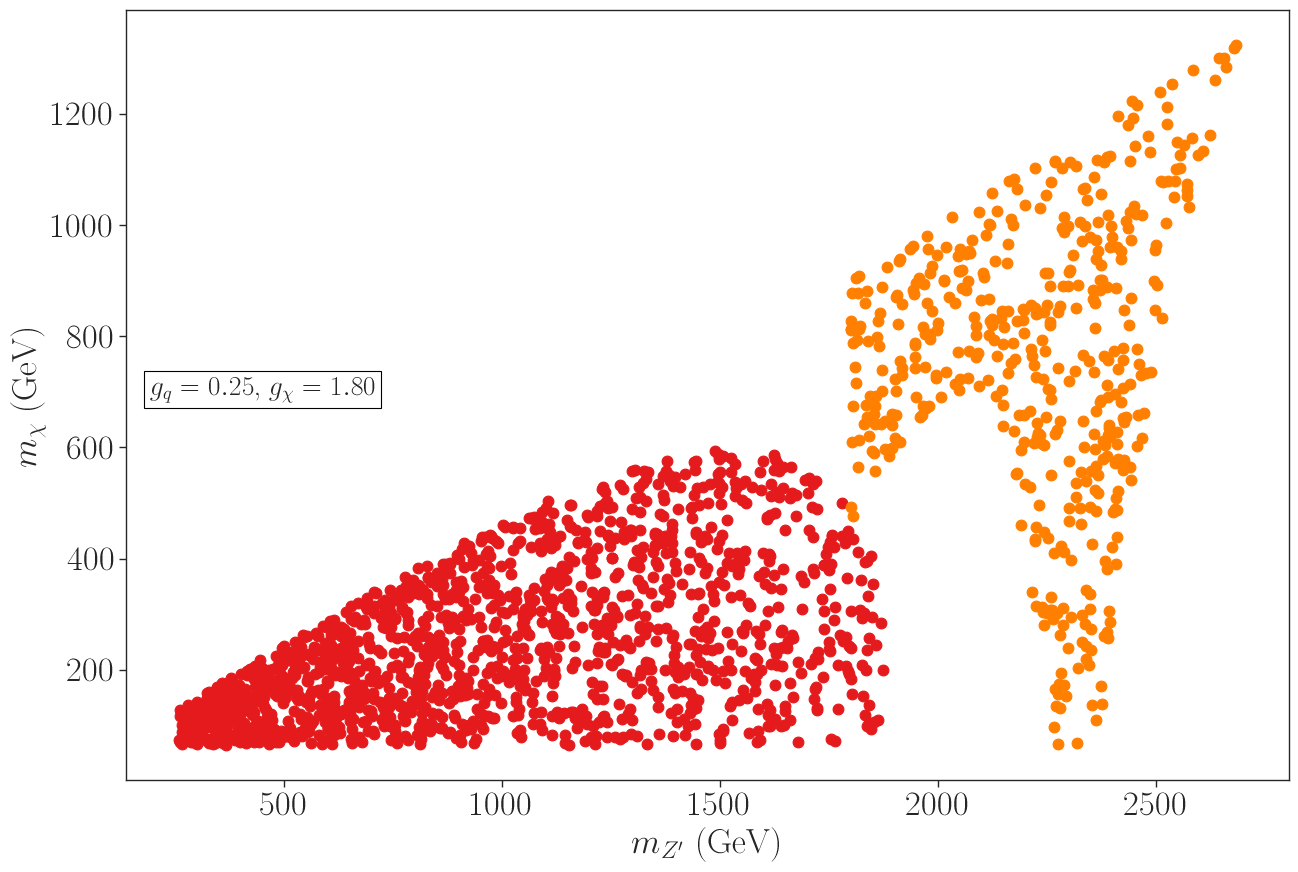

In [32]:
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(15,10))

gqv = 0.25
gchi = 1.8


for label in excluded['label'].unique():
    
#     data = newDF.sort_values('ExptRes.result.r_expected').drop_duplicates(["filename"],keep='last')
    data = newDF.sort_values('ExptRes.result.r').drop_duplicates(['filename'], keep='last')
    data = data[(data['extpar.1']==gchi)&(data['extpar.2']==gqv)&(data['ExptRes.result.r']>=1.0)]
    data = data[data['label']==label]
    
    x = data['mass.9900032'].dropna()
    y = data['mass.9000006'].dropna()
    c = data['ExptRes.result.r'].dropna()
    sc = plt.scatter(x,y,s=60, color=colorDict[label])
    

# cb = plt.colorbar(sc)
# cb.ax.tick_params(labelsize=25)
# cb.set_label(label=r'$r$',size=25)

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

CMS-EXO-20-004 (TRV1)
CMS-EXO-19-012 (TRV1jj)


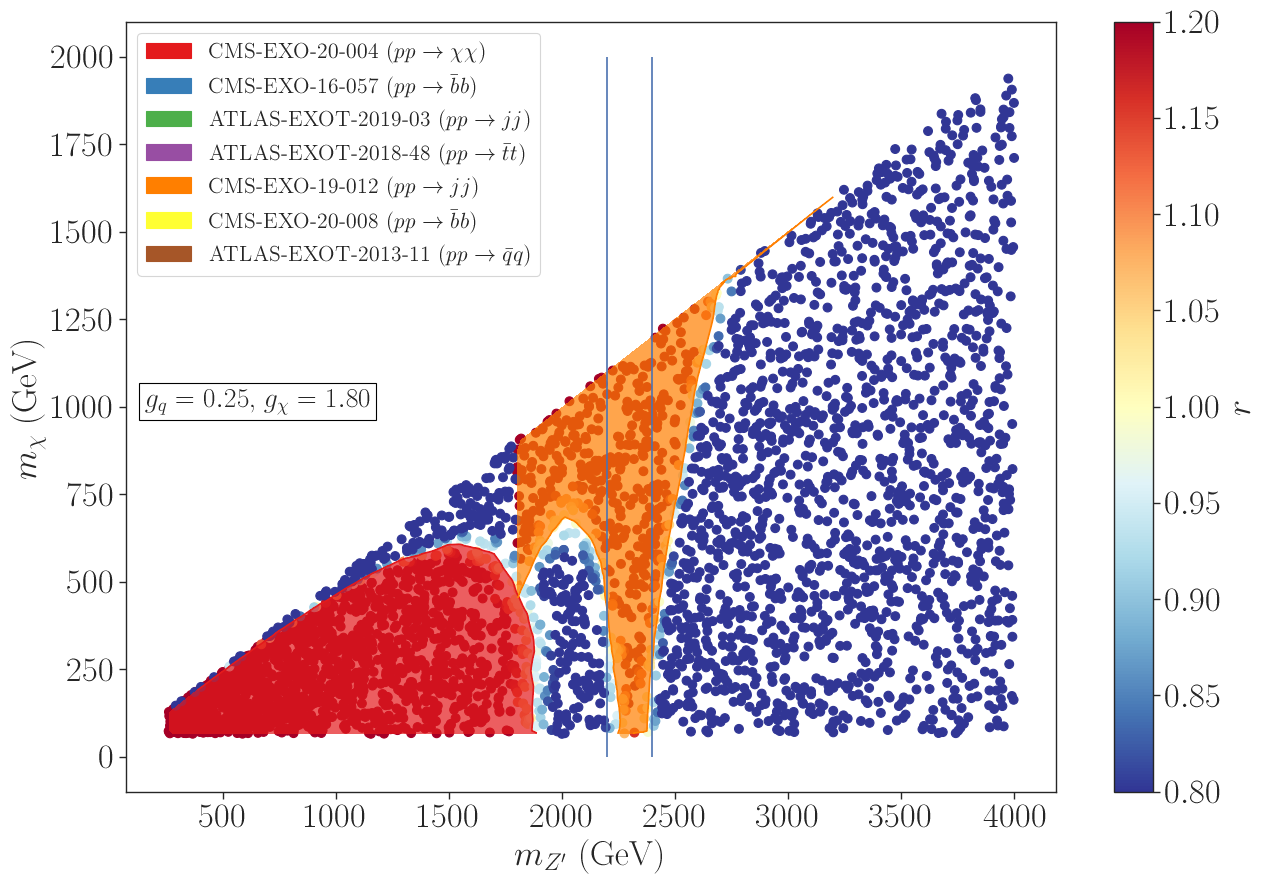

In [34]:
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(15,10))

gqv = 0.25
gchi = 1.8


x = dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
y = dataDF['mass.9000006'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
c = dataDF['ExptRes.result0.r'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()

sc = plt.scatter(x,y,c=c,s=40,cmap=cm, vmin=0.8,vmax=1.2)

for label in excluded['label'].unique():
    if 'CMS-EXO-16-057'  in label : continue
    if 'ATLAS-EXOT-2019-03' in label: continue
    if 'ATLAS-EXOT-2018-48' in label: continue
    if 'CMS-EXO-20-008' in label: continue
    if 'ATLAS-EXOT-2013-11' in label: continue
    if 'CMS-EXO-12-059' in label: continue
    print(label)
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r']
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.7, colors=colorDict[label])
    
    
plt.legend(handles=[legend[0], legend[1], legend[2], legend[3], legend[4], legend[5], legend[6]], fontsize=16)

cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=25)
cb.set_label(label=r'$r$',size=25)

# plt.hlines(402, 260,4000, colors='black')
plt.vlines(2200, 0, 2000)
plt.vlines(2400, 0, 2000)


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

In [48]:
dataDF[(dataDF['mass.9900032']>2000)&(dataDF['mass.9900032']<2200)&(dataDF['ExptRes.result0.r']<1)&(dataDF['extpar.1']==1.8)&(dataDF['extpar.2']==0.25)]

filename  mass.9000006  mass.9900032  mass.9000002   
32622  scan_ekl8pj9u.slha     565.29500      2166.806       91.1876  \
19250  scan_wysm4paq.slha     672.98430      2046.206       91.1876   
30578  scan_r4cwvxo7.slha     647.31880      2051.153       91.1876   
839    scan_usno3pvk.slha     651.12540      2001.740       91.1876   
17721  scan_i02sz2oi.slha     521.45280      2157.368       91.1876   
37848  scan_t8jz0qv3.slha     577.98370      2098.633       91.1876   
9570   scan_sby_7404.slha     402.00580      2174.456       91.1876   
41079  scan_qg1lbfg5.slha     510.30590      2134.117       91.1876   
9826   scan_mexxs1k_.slha     534.83030      2107.993       91.1876   
44039  scan_0tkbex3g.slha     445.63530      2162.991       91.1876   
25405  scan_t1g4ieu_.slha     465.75880      2149.189       91.1876   
4713   scan_0q_jec74.slha     570.53800      2000.766       91.1876   
1148   scan_ek3c0hpt.slha     528.53920      2096.819       91.1876   
23686  scan_q09v92oi.slha     439.84050      2148.850       91.1876   
23168  scan_j5pw_1ya.slha     479.02260      2123.538       91.1876   
23189  scan_jplskcx8.slha     286.83980      2014.719       91.1876   
13719  scan_dj4cjh_o.slha     486.94270      2103.563       91.1876   
42043  scan_rnwhufru.slha     274.81620      2014.373       91.1876   
39942  scan_30vb9vh9.slha     235.77160      2011.595       91.1876   
28900  scan_u_qekq__.slha     226.39630      2177.630       91.1876   
22291  scan_gcet6wx2.slha     421.57040      2144.677       91.1876   
13815  scan_pd7v_kxy.slha     448.66940      2127.933       91.1876   
16745  scan_0css0zyw.slha     271.26080      2022.081       91.1876   
23525  scan_ohy717wf.slha     193.28450      2017.383       91.1876   
918    scan_t7wik0ih.slha     234.27420      2033.607       91.1876   
49858  scan_7_9_rdn7.slha     183.72330      2031.048       91.1876   
26432  scan_1hpd0cqn.slha     111.05870      2024.779       91.1876   
44176  scan_w0zfl8_d.slha     263.04930      2040.162       91.1876   
6929   scan_9tjwaqp7.slha     201.43670      2035.666       91.1876   
5247   scan_l3it221l.slha     331.43930      2154.855       91.1876   
42988  scan_d1b5e6h_.slha     506.93970      2028.565       91.1876   
246    scan_40tz3a8y.slha     504.69300      2018.375       91.1876   
47944  scan_xo4xbau3.slha     503.30350      2012.181       91.1876   
19634  scan_upaquu8x.slha     429.19370      2025.078       91.1876   
43633  scan_k5415cej.slha     489.96090      2077.809       91.1876   
34445  scan_1drfzmak.slha     364.50410      2122.183       91.1876   
43914  scan_z__16h15.slha     302.41210      2150.627       91.1876   
42931  scan_cqds6c6q.slha     487.67020      2061.438       91.1876   
17899  scan_hdhru2_d.slha     320.69400      2135.177       91.1876   
34483  scan_x42pr8_5.slha     436.27800      2085.897       91.1876   
802    scan_6xgo1ipw.slha     308.29540      2138.552       91.1876   
28021  scan_uahbqgjh.slha     474.52220      2044.400       91.1876   
2343   scan_3_1n6m0x.slha     422.67010      2061.777       91.1876   
11146  scan_qxq_46sv.slha     470.93760      2045.294       91.1876   
11691  scan_x8zui0h7.slha     457.67490      2041.367       91.1876   
5999   scan_dhuhlw87.slha     315.62750      2128.054       91.1876   
24430  scan_mt4897s6.slha      70.39675      2070.386       91.1876   
22046  scan__wxv765v.slha     281.88080      2135.371       91.1876   
16483  scan_xbe19yem.slha     110.71380      2073.287       91.1876   
39649  scan__m9q9rob.slha     396.21390      2073.081       91.1876   
2261   scan_gksfa4lc.slha     317.75940      2107.932       91.1876   
30240  scan_c4678yz5.slha     109.90890      2082.898       91.1876   
37805  scan_hqstl2t5.slha     197.37050      2097.696       91.1876   
25130  scan_474oq3uu.slha     225.72440      2132.562       91.1876   
5216   scan_nu37f5_8.slha     172.51080      2108.732       91.1876   
20238  scan_rhhabapa.slha     120.43690  

In [53]:
dataDF['mass.9900032'][dataDF['filename']=='scan_sby_7404.slha']

9570    2174.456
Name: mass.9900032, dtype: float64

In [54]:
dataDF['width.9900032'][dataDF['filename']=='scan_sby_7404.slha']

9570    139.8352
Name: width.9900032, dtype: float64

In [56]:
4.2053e-01*7.733998e-02*5*1000

162.61890894700005

In [57]:
1.626E+02/1.984E+02

0.8195564516129031

In [58]:
0.1209188948740557*1e3

120.9188948740557

In [41]:
excluded['label'].unique()

array(['CMS-EXO-20-004 (TRV1)', 'CMS-EXO-16-057 (TRV1bb)',
       'ATLAS-EXOT-2019-03 (TRV1jj)', 'ATLAS-EXOT-2018-48 (TRV1tt)',
       'CMS-EXO-20-008 (TRV1bb)', 'CMS-EXO-19-012 (TRV1jj)',
       'ATLAS-EXOT-2013-11 (TRV1qq)'], dtype=object)

In [43]:
colors = {'monojet': 'cyan', 'dijet': 'magenta'}

In [44]:
legend = []
for label, color in colors.items():
    l = mpatches.Patch(color=color, label=label)
    legend.append(l)

CMS-EXO-20-004 (TRV1)
ATLAS-EXOT-2019-03 (TRV1jj)
CMS-EXO-19-012 (TRV1jj)
ATLAS-EXOT-2013-11 (TRV1qq)


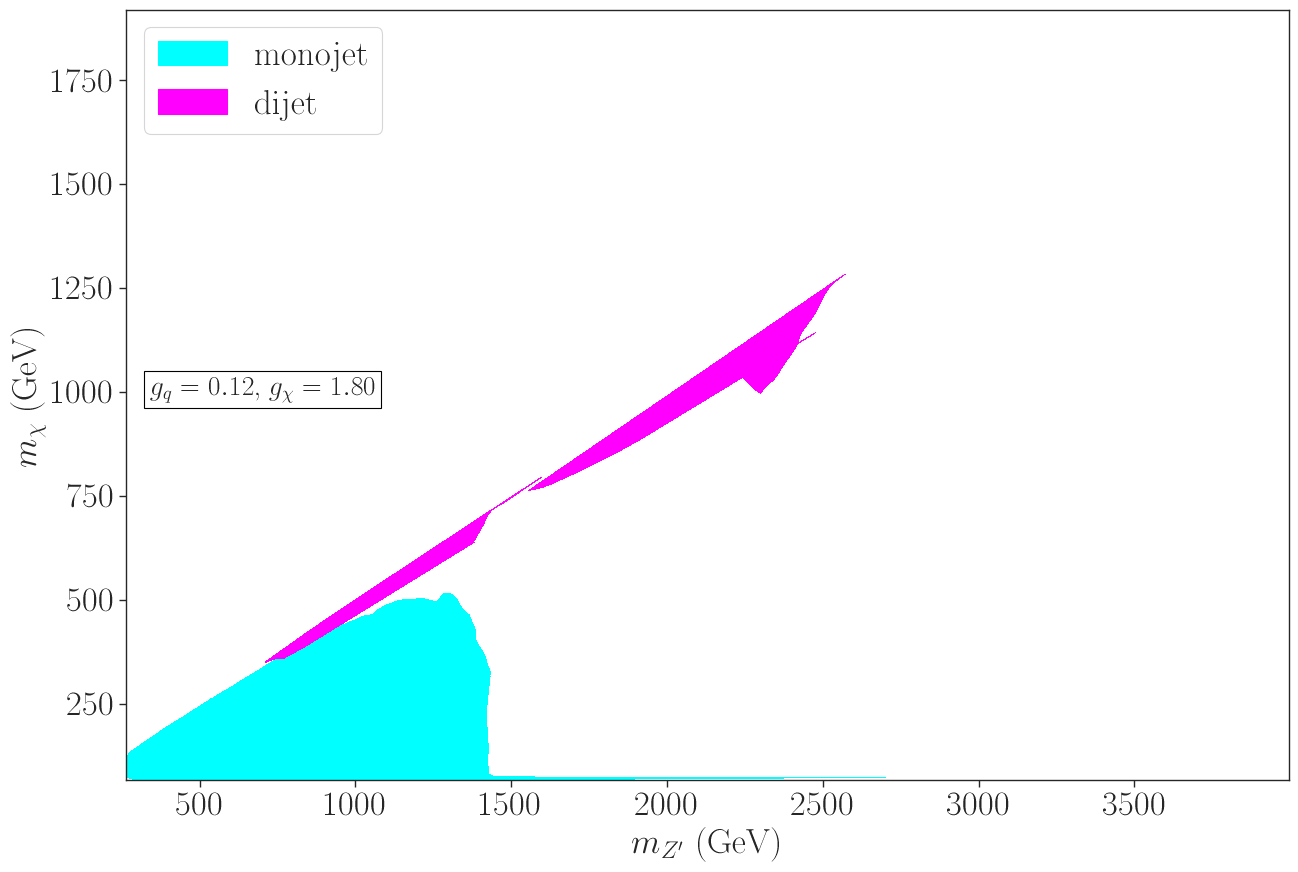

In [58]:
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(15,10))

gqv = 0.125
gchi = 1.8

# x = dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.3']==gqv)].dropna()
# y = dataDF['mass.9000006'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.3']==gqv)].dropna()
# c = dataDF['ExptRes.result0.r'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.3']==gqv)].dropna()

# sc = plt.scatter(x,y,c=c,s=40,cmap=cm, vmin=0.8,vmax=1.2)

for label in excluded['label'].unique():
    if 'CMS-EXO-16-057' in label: continue
    if 'ATLAS-EXOT-2018-48' in label: continue
    if 'CMS-EXO-20-008' in label: continue
#     if 'ATLAS-EXOT-2013-11' in label: continue
#     if 'ATLAS-EXOT-2019-03' in label: continue
    print(label)
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r']
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    if 'CMS-EXO-20-004' in label:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=1.0, colors='cyan')
    else:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=1.0, colors='magenta')
    
    
plt.legend(handles=[legend[0], legend[1]], fontsize=25, loc='upper left')

# cb = plt.colorbar(sc)
# cb.ax.tick_params(labelsize=25)
# cb.set_label(label=r'$r$',size=25)

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

In [48]:
newDF['extpar.1'].unique()

array([4.5     , 3.      , 2.5     , 1.8     , 1.414214])

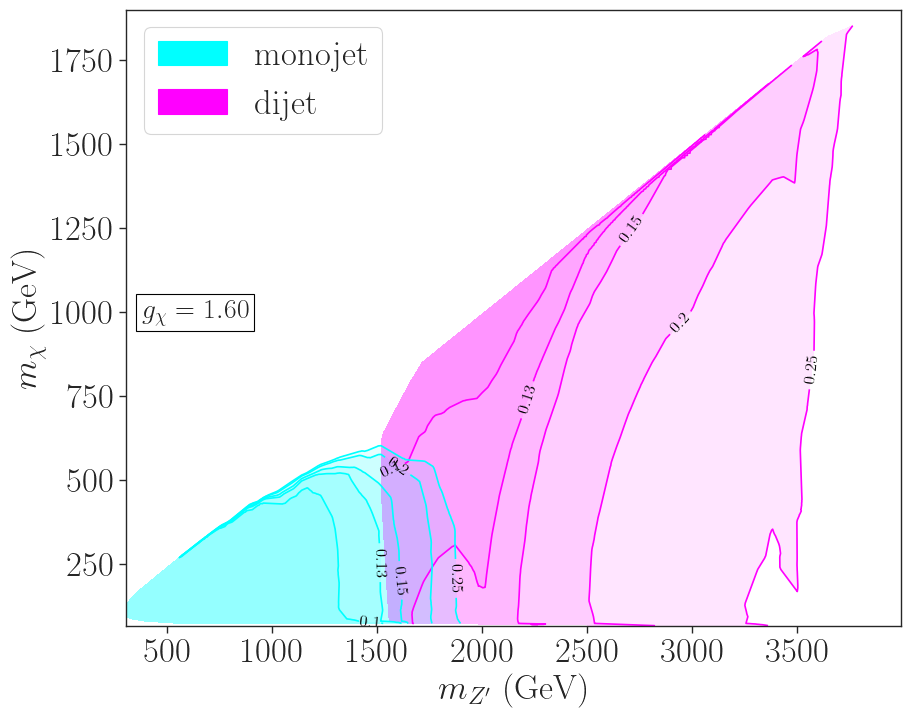

In [74]:
plt.figure(figsize=(10,8))

# anas = ['CMS-EXO-20-004 (TRV1)', 'ATLAS-EXOT-2019-03', ]
gqa_list = [0.1, 0.13, 0.15, 0.2, 0.25]
# gqa_list = [0.1]
gchi = 1.6
for gqa in gqa_list:
    for label in excluded['label'].unique():
        if not 'CMS-EXO-20-004' in label and not 'ATLAS-EXOT-2019-03' in label: continue
        data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqa) & (newDF['label']==label)]
        rData = data['ExptRes.result.r']
        pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
        rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
        pts = pts[~np.isnan(rPts)]
        rPts = rPts[~np.isnan(rPts)]
        if 'CMS-EXO-20-004' in label:
            cs1 = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors='cyan')
            plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.1, colors='cyan')
            plt.clabel(cs1, fontsize=12, fmt=str(gqa), inline=True, colors='black')
            cs1.collections[0].set_label(str(gqa))
        else:
            cs2 = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors='magenta')
            plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.1, colors='magenta')    
            plt.clabel(cs2, fontsize=12, fmt=str(gqa), inline=True, colors='black')
            cs2.collections[0].set_label(str(gqa))
        

plt.legend(handles=[legend[0], legend[1]], fontsize=25, loc='upper left')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{\chi} = %1.2f$' % (gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

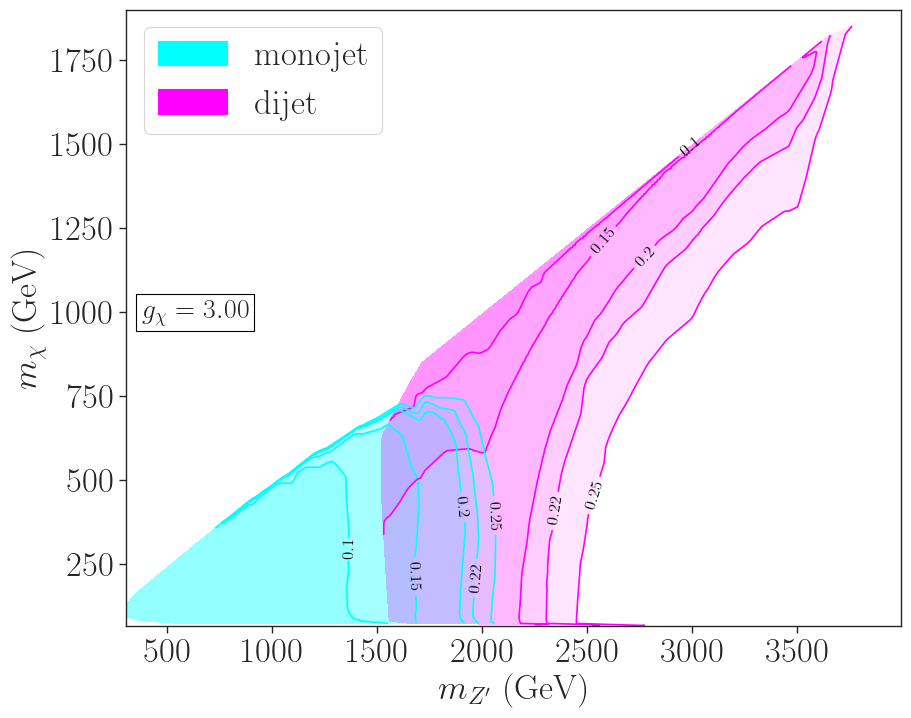

In [75]:
plt.figure(figsize=(10,8))

gqa_list = [0.1, 0.15, 0.2, 0.22, 0.25]
gchi = 3.0
for gqa in gqa_list:
    for label in excluded['label'].unique():
        if not 'CMS-EXO-20-004' in label and not 'ATLAS-EXOT-2019-03' in label: continue
        data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqa) & (newDF['label']==label)]
        rData = data['ExptRes.result.r']
        pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
        rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
        pts = pts[~np.isnan(rPts)]
        rPts = rPts[~np.isnan(rPts)]
        if 'CMS-EXO-20-004' in label:
            cs1 = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors='cyan')
            plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.1, colors='cyan')
            plt.clabel(cs1, fontsize=12, fmt=str(gqa), inline=True, colors='black')
            cs1.collections[0].set_label(str(gqa))
        else:
            cs2 = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors='magenta')
            plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.1, colors='magenta')    
            plt.clabel(cs2, fontsize=12, fmt=str(gqa), inline=True, colors='black')
            cs2.collections[0].set_label(str(gqa))
        

plt.legend(handles=[legend[0], legend[1]], fontsize=25, loc='upper left')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{\chi} = %1.2f$' % (gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

CMS-EXO-20-004 (TRV1)
ATLAS-EXOT-2019-03 (TRV1jj)
CMS-EXO-12-059 (TRV1qq)


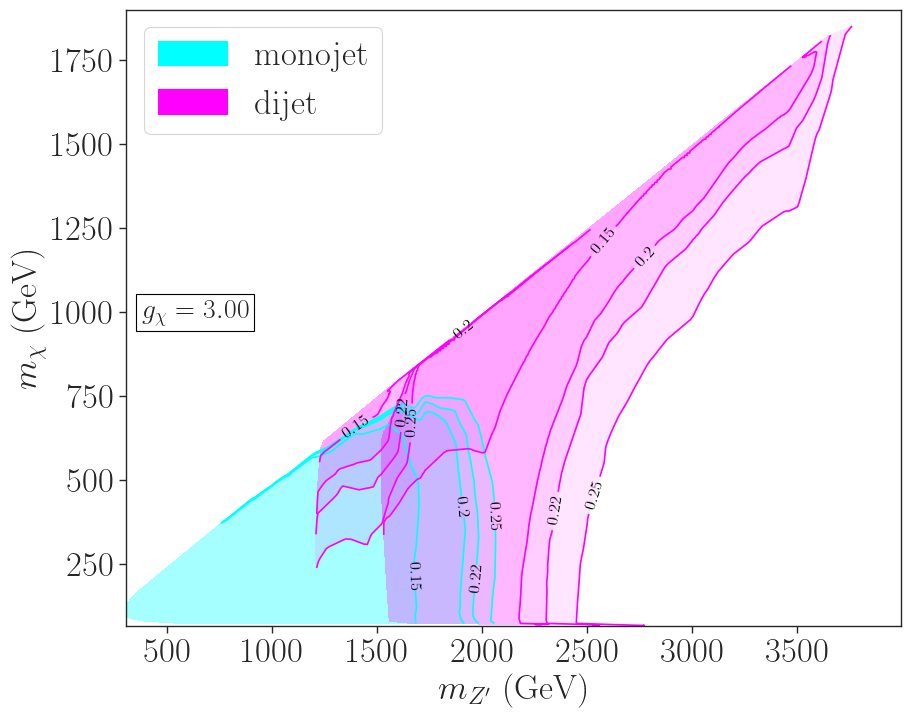

In [80]:
plt.figure(figsize=(10,8))

gqa_list = [0.15, 0.2, 0.22, 0.25]
gchi = 3.0
for label in excluded['label'].unique():
    if 'CMS-EXO-16-057' in label: continue
    if 'ATLAS-EXOT-2018-48' in label: continue
    if 'CMS-EXO-20-008' in label: continue
    if 'CMS-PAS-EXO-20-008' in label: continue
    if 'CMS-EXO-19-012' in label: continue
    print(label)
    for gqa in gqa_list:
        data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqa) & (newDF['label']==label)]
        rData = data['ExptRes.result.r']
        pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
        rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
        pts = pts[~np.isnan(rPts)]
        rPts = rPts[~np.isnan(rPts)]
        if 'CMS-EXO-20-004' in label:
            cs1 = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors='cyan')
            plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.1, colors='cyan')
            plt.clabel(cs1, fontsize=12, fmt=str(gqa), inline=True, colors='black')
            cs1.collections[0].set_label(str(gqa))
        else:
            cs2 = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors='magenta')
            plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.1, colors='magenta')    
            plt.clabel(cs2, fontsize=12, fmt=str(gqa), inline=True, colors='black')
            cs2.collections[0].set_label(str(gqa))
        

plt.legend(handles=[legend[0], legend[1]], fontsize=25, loc='upper left')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{\chi} = %1.2f$' % (gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

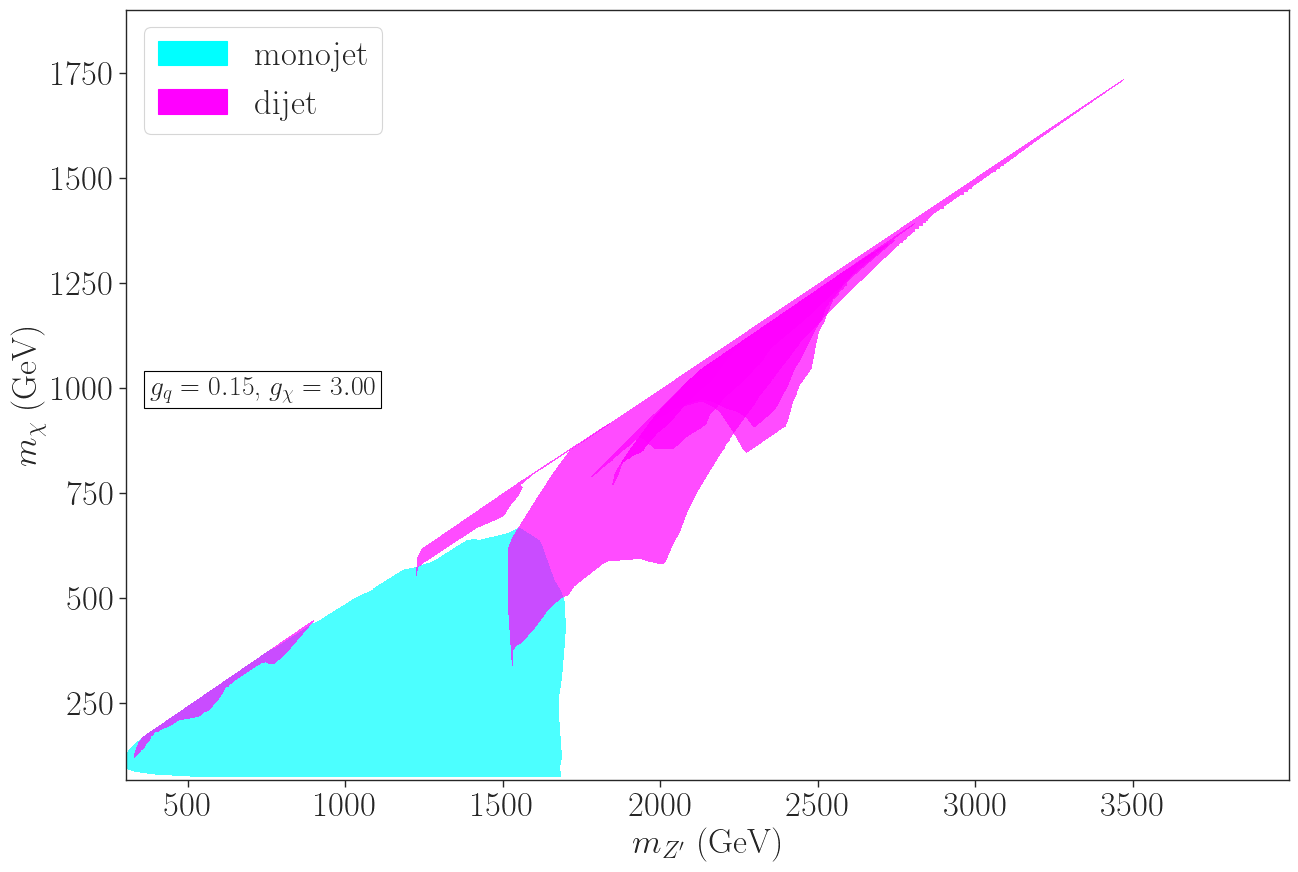

In [40]:
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(15,10))

gqa = 0.15
gchi = 3.0


for label in excluded['label'].unique():
#     if 'CMS-EXO-20-004' not in label: continue
#     if 'ATLAS-EXOT-2019-03' not in label: continue
#     if 'CMS-EXO-19-012' not in label: continue
#     print(label)
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqa) & (newDF['label']==label)]
    rData = data['ExptRes.result.r']
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    if 'CMS-EXO-20-004' in label:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.7, colors='cyan')
    else:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.7, colors='magenta')
    
    
plt.legend(handles=[legend[0], legend[1]], fontsize=25, loc='upper left')


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqa, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

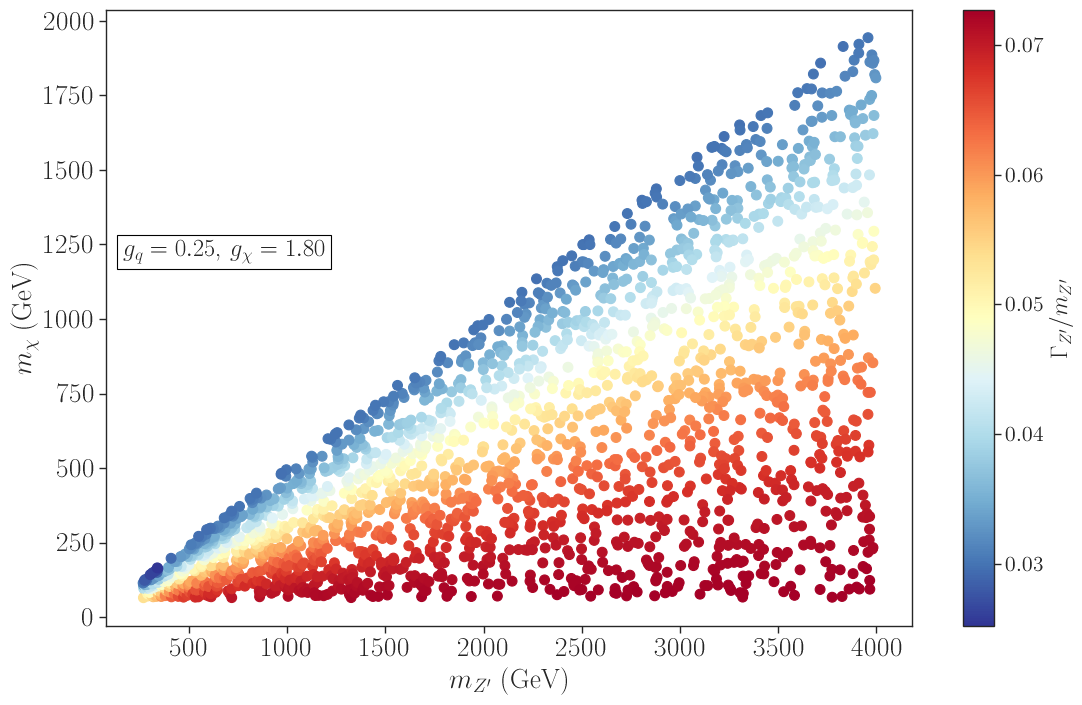

In [61]:
plt.colormaps['RdYlBu_r']
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))

gqv = 0.25
gchi = 1.8

x = dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
y = dataDF['mass.9000006'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()
c = dataDF['width.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()/dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)].dropna()

plt.scatter(x,y,c=c,s=50,cmap=cm)
plt.colorbar(label=r'$\Gamma_{Z^{\prime}} / m_{Z^{\prime}}$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=20)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=20)
plt.text(0.02,0.6,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=18,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.savefig('ratio_wm_2mdm.png')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [411]:
# reescale r to match gq = 0.2
def rescale_r(anaID, r, gq, gq_new=0.2):
    """
    Function that receives values for analysis ID, r, and the coupling to quarks and reescales the value of r
    depending on the process (pp -> qq or pp -> dm dm). For analysis involving dijets, the r will reescale as 
    (gq_new/gq)**4, while for analysis involving dm, it will reescale as (gq_new/gq)**2
    :param values: refer to columns 'ExptRes.result.AnalysisID', 'ExptRes.result.r', and 'extpar.2', in this order
    :return: reescaled r for selected gq
    """
    gqv = 0.25
    k_dijets = (gq_new/gq)**4
    k_dm = (gq_new/gq)**2
    k_dm2 = (4.0/1.6)**2
#     k_dm2 = 1
#     k_dm = 1
#     k_dijets = 1
    if gq == gqv:
        if anaID == 'CMS-EXO-20-004':
            return r*k_dm*k_dm2
        else:
            return r*k_dijets
    else: return r
    

In [423]:
newDF['ExptRes.result.r_new'] = newDF.apply(lambda x: rescale_r(anaID=x['ExptRes.result.AnalysisID'],
                                                                r=x['ExptRes.result.r'], gq=x['extpar.3'],
                                                                gq_new=0.15), axis=1)

In [424]:
newDF = newDF.sort_values(by=['filename', 'ExptRes.result.r_new', 'label'],ascending=[True, True, False])

In [425]:
colors = {'monojet': 'cyan', 'dijet': 'magenta'}

In [426]:
legend = []
for label, color in colors.items():
    l = mpatches.Patch(color=color, label=label)
    legend.append(l)

CMS-EXO-20-004 (TRV1) (13 TeV)
ATLAS-EXOT-2019-03 (TRV1jj) (13 TeV)


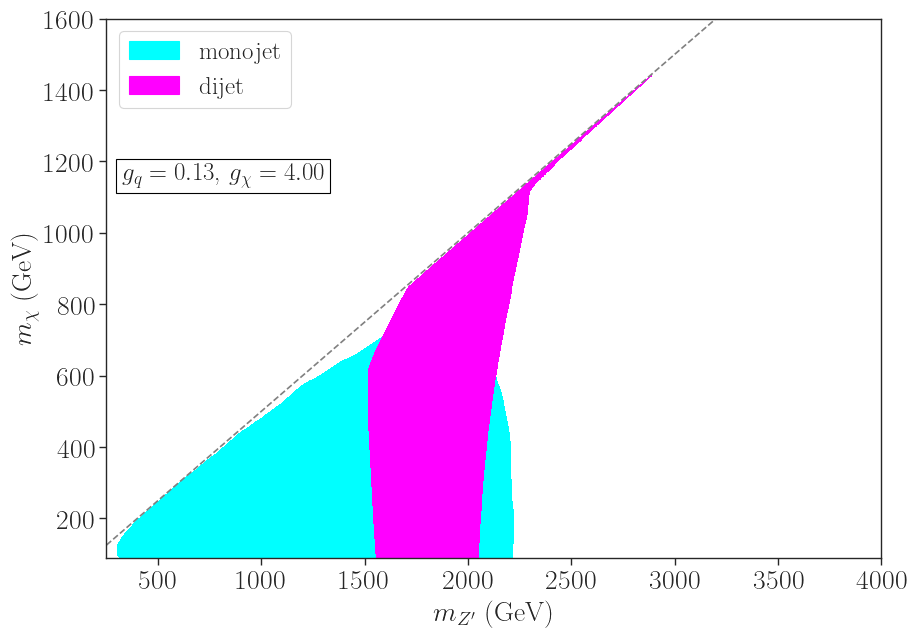

In [427]:
plt.colormaps['RdYlBu_r']
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,7))

gqv = 0.25
gchi = 1.6
gqv_new = 0.13
gchi_new = 4.0

# x = newDF['mass.9900032'][(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqv)]
# y = newDF['mass.9000006'][(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqv)]
# c = newDF['ExptRes.result.r_new'][(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqv)]
# sr = plt.scatter(x,y,c=c,s=40,cmap=cm, vmin=0.8,vmax=1.2)

for label in excluded['label'].unique():
#     if not 'CMS-EXO-20-004' in label and not 'ATLAS-EXOT-2019-03' in label: continue
    if 'CMS-EXO-16-057' in label: continue
    if 'CMS-EXO-12-059' in label: continue
    if 'ATLAS-EXOT-2018-48' in label: continue
    if 'CMS-EXO-20-008' in label: continue
    if 'ATLAS-EXOT-2013-11' in label: continue
    print(label)
#     print(label)
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.3']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r_new']
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,1800.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
#     cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label])
    if 'CMS-EXO-20-004' in label:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=1.0, colors='cyan')
    else:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=1.0, colors='magenta')
    
    
plt.legend(handles=[legend[0], legend[1]], fontsize=18, loc='upper left')


# plt.colorbar(sr, label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=20)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=20)
plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')
plt.text(0.02,0.7,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv_new, gchi_new),fontsize=18,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)
# plt.plot(cmsCurve['m_med_GeV'],cmsCurve['m_chi_GeV'],label='CMS-EXO-20-004 (axial)',linewidth=2,color='black')

plt.xlim(250.0, 4000.0)
plt.ylim(90.0,1600.0)
# plt.savefig('exclusions_2mdm_reescaled_monojet.png')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [127]:
colorDict = {}

for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)

In [128]:
colorDict

{'CMS-EXO-20-004 (TRV1) (13 TeV)': array([[0.10588235, 0.61960784, 0.46666667]]),
 'CMS-EXO-16-057 (TRV1bb) (8 TeV)': array([[0.85098039, 0.37254902, 0.00784314]]),
 'ATLAS-EXOT-2019-03 (TRV1jj) (13 TeV)': array([[0.45882353, 0.43921569, 0.70196078]]),
 'CMS-EXO-12-059 (TRV1qq) (8 TeV)': array([[0.90588235, 0.16078431, 0.54117647]]),
 'ATLAS-EXOT-2018-48 (TRV1tt) (13 TeV)': array([[0.4       , 0.65098039, 0.11764706]]),
 'CMS-EXO-20-008 (TRV1bb) (13 TeV)': array([[0.90196078, 0.67058824, 0.00784314]]),
 'ATLAS-EXOT-2013-11 (TRV1qq) (8 TeV)': array([[0.65098039, 0.4627451 , 0.11372549]])}

In [ ]:
newDF

### Validate exclusion curve for CMS-EXO-20-004

In [35]:
cmsCurve = np.genfromtxt('2Dexclusioncontour,axial,Observed.csv', skip_header=12,names=True,delimiter=',')

In [36]:
## Get results with rescaled xsection that matches gchi = 1.0
pclFiles = ['../../scan/smodels_results/scan_results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF_rescaled = pd.concat(dfs, ignore_index=True)

In [37]:
idCols = [c for c in dataDF_rescaled.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF_rescaled.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID']


In [38]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [39]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [40]:
filteredDF_rescaled = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF_rescaled.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF_rescaled.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF_rescaled.append(newrow)  

In [41]:
newDF_rescaled = pd.DataFrame.from_dict(filteredDF_rescaled)

In [42]:
labels = []
for index, row in newDF_rescaled.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF_rescaled['label'] = labels

In [43]:
colors = sns.color_palette("colorblind",len(excluded['label'].unique()))

colorDict = {}
for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)
    
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=convertLabel(ana))
    legend.append(l)

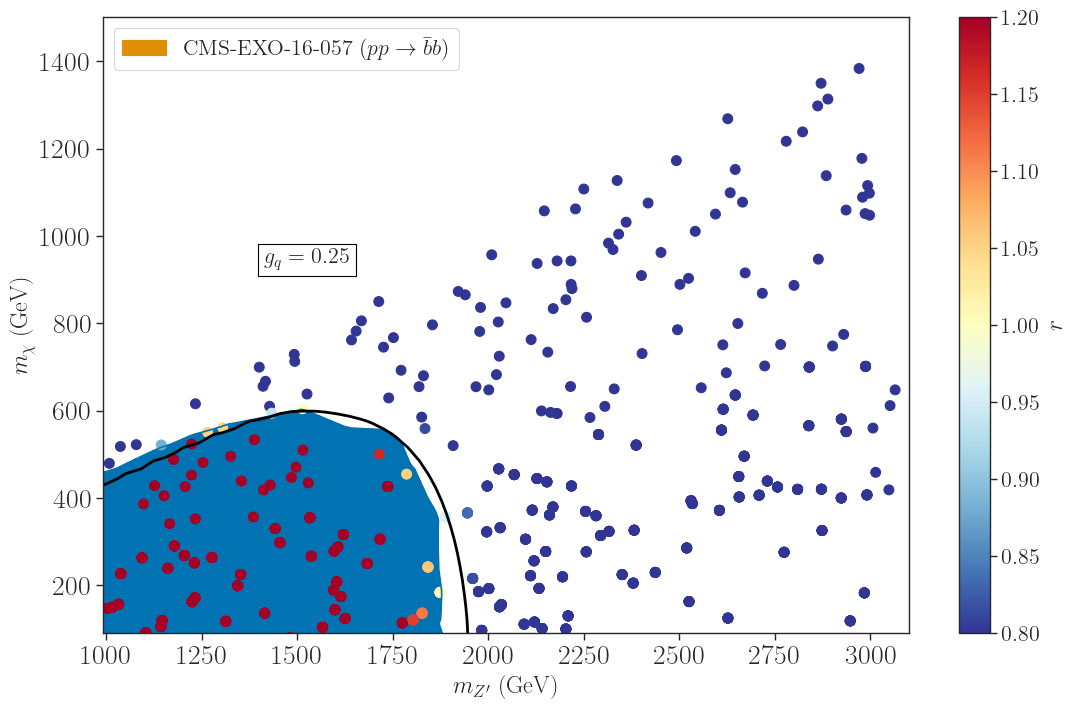

In [44]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(13,8))

gqv = 0.25
curve = 'CMS-EXO-20-004'

x = newDF_rescaled['mass.9900032'][newDF_rescaled['ExptRes.result.AnalysisID'] == curve]
y = newDF_rescaled['mass.9000006'][newDF_rescaled['ExptRes.result.AnalysisID'] == curve]
c = newDF_rescaled['ExptRes.result.r'][newDF_rescaled['ExptRes.result.AnalysisID'] == curve]

data = newDF_rescaled[(newDF_rescaled['ExptRes.result.AnalysisID']==curve)]
rData = data['ExptRes.result.r']
pts = np.array([y for y in product(np.linspace(900.,4100.,300),np.linspace(0.,1800.,300))])
rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]

cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict['CMS-EXO-20-004 (TRV1)'])
plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], colors=colorDict['CMS-EXO-20-004 (TRV1)'])


plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0.8,vmax=1.2)

plt.plot(cmsCurve['m_med_GeV'],cmsCurve['m_chi_GeV'],label='CMS-EXO-20-004 (axial)',linewidth=2,color='black')

plt.legend(handles=[legend[1]])

plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
plt.text(0.2,0.6,r"$g_{q} = %1.2f$" %gqv,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = plt.gca().transAxes)

plt.xlim(990.0, 3100.0)
plt.ylim(90.0,1500.0)
# plt.savefig('2mdm_validation.png')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

### Scan over $\alpha$ 

In [ ]:
#Merge with SModelS DataFrame
pclFiles = {'all': '../../data/2mdm_results_scan_alpha_v3/all/results.pcl',
            'zp': '../../data/2mdm_results_scan_alpha_v3/zp_only/results.pcl',
            'sd': '../../data/2mdm_results_scan_alpha_v3/sd_only/results.pcl'}

dataDF = pd.DataFrame()
for label, f in pclFiles.items():
    df = pd.read_pickle(f)
    df['process'] = label
    dataDF = pd.concat((dataDF, df))

In [ ]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

In [ ]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]

In [ ]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [ ]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [ ]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [ ]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [ ]:
labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels
newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')


In [ ]:
dfAll = newDF[(newDF['process']=='all')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [ ]:
# plot values of r for sd only
dfSd = newDF[(newDF['process']=='sd')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [ ]:
dfSd['extpar.1'].unique()

array([1.      , 1.414214])

In [ ]:
dfSd = dfSd[dfSd['extpar.1']==1.414214]

In [ ]:
zpMasses = dfSd['mass.9900032'].unique().tolist()

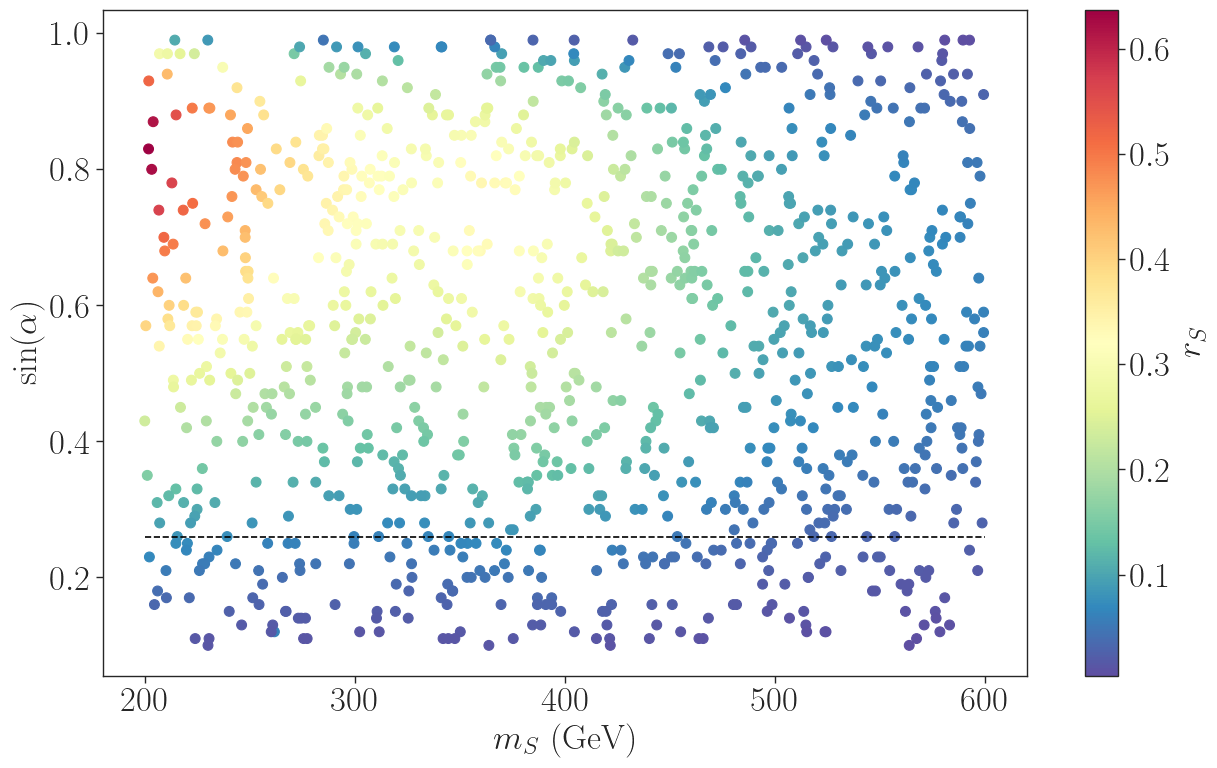

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(13,8))

mzp = 2000.0
x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
c = dfSd['ExptRes.result.r'][dfSd['mass.9900032']==mzp]

plt.hlines(0.26, 200, 600, linestyle='--', color='black')

im = plt.scatter(x,y,c=c,s=50,cmap=cm)
cb = plt.colorbar(im)
cb.set_label(label=r'$r_{S}$', size=25)

#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)
    
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=25)
plt.ylabel(r'$\sin(\alpha$)', fontsize=25)
    
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
im.figure.axes[0].tick_params(axis="both", labelsize=25) 
im.figure.axes[1].tick_params(axis="y", labelsize=25) 


plt.savefig('2mdm_rs.png')
plt.tight_layout()
plt.show()

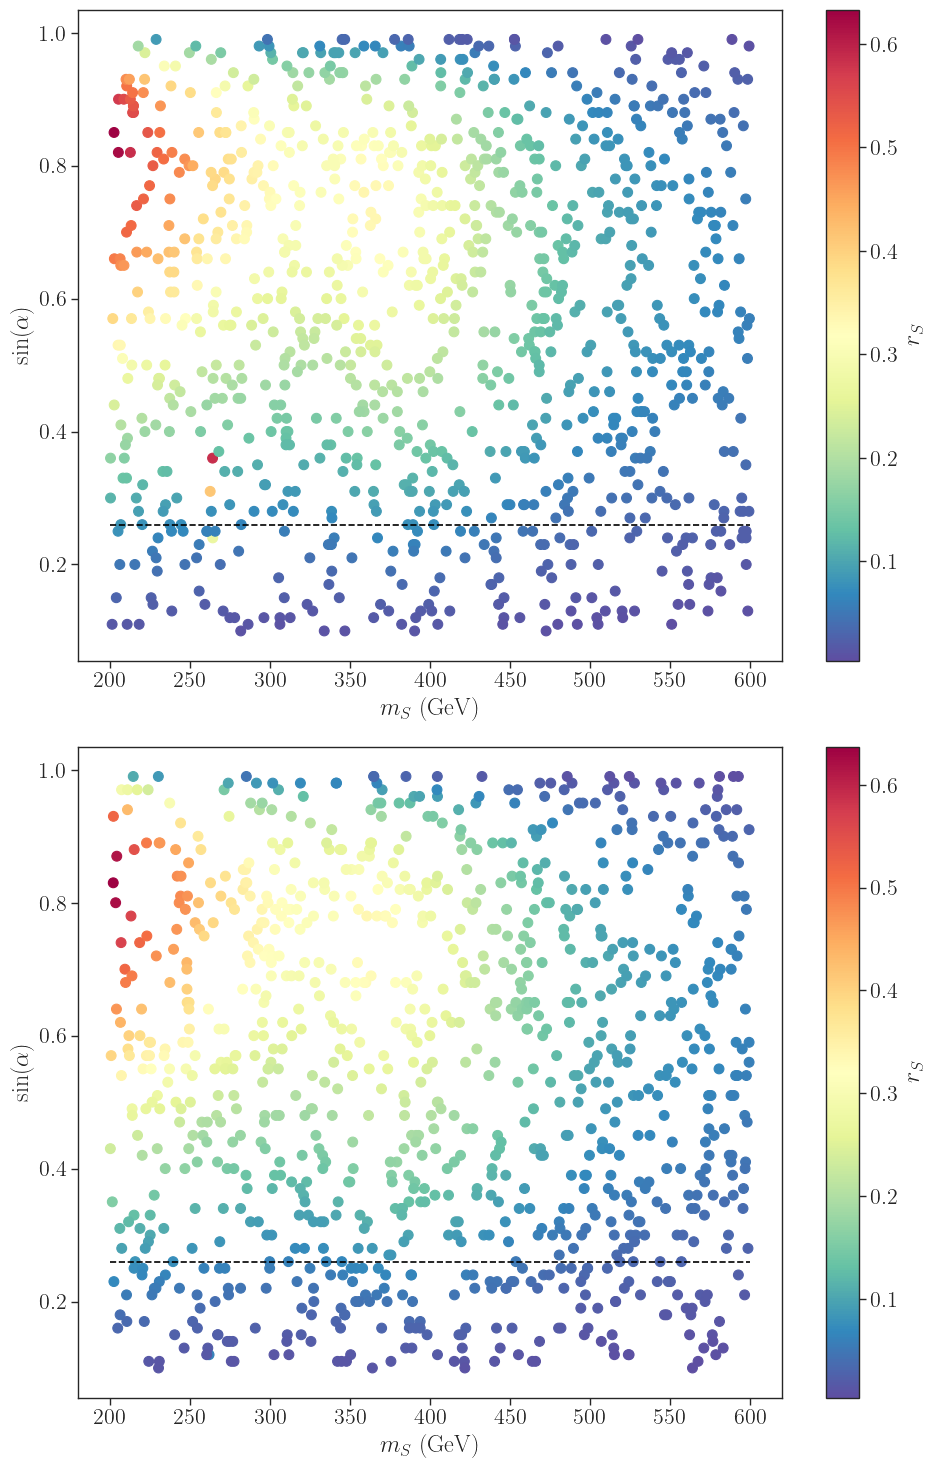

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
fig, ax = plt.subplots(len(zpMasses), figsize=(10,15))

zpMasses.sort()
for i, mzp in enumerate(zpMasses):
    x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
    y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
    c = dfSd['ExptRes.result.r'][dfSd['mass.9900032']==mzp]
    
    ax[i].hlines(0.26, 200, 600, linestyle='--', color='black')
    
    im = ax[i].scatter(x,y,c=c,s=50,cmap=cm)
    plt.colorbar(im, label=r'$r_{S}$', ax=ax[i])
    
#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)
    
    ax[i].set_xlabel(r'$m_{S}$ (GeV)')
    ax[i].set_ylabel(r'$\sin(\alpha$)')
    

fig.tight_layout()
plt.show()

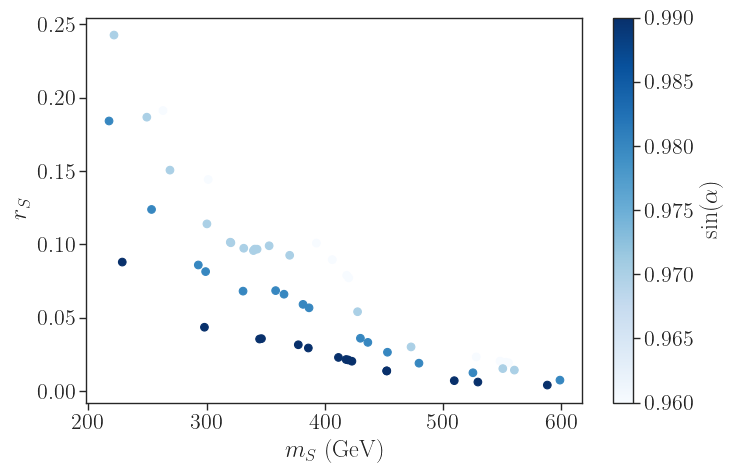

In [ ]:
cm = plt.cm.get_cmap('Blues')
plt.figure(figsize=(8,5))

m = 1750
sa = 0.95
x = dfSd['mass.9900026'][(dfSd['extpar.6']>sa)&(dfSd['mass.9900032']==m)]
y = dfSd['ExptRes.result.r'][(dfSd['extpar.6']>sa)&(dfSd['mass.9900032']==m)]
c = dfSd['extpar.6'][(dfSd['extpar.6']>sa)&(dfSd['mass.9900032']==m)]


im = plt.scatter(x, y, c=c, s=30,cmap=cm)
plt.colorbar(im, label=r'$\sin(\alpha)$')

plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$r_{S}$')
plt.show()

In [ ]:
dfZp = newDF[(newDF['process']=='zp')&(newDF['ExptRes.result.AnalysisID']=='CMS-EXO-20-004')]

In [ ]:
dfAll = dfAll[dfAll['ExptRes.result.r']>=0.6]

In [ ]:
# dfZp = dfZp[dfZp['ExptRes.result.r']>=0.4]

In [ ]:
dfAll = dfAll.drop_duplicates(subset='filename')

In [ ]:
mCols = ['mass.9900026', 'mass.9000006']
keys = list(dfAll[mCols].columns.values)
i1 = dfAll.set_index(keys).index
i2 = dfZp.set_index(keys).index
dfAll = dfAll[i1.isin(i2)]
dfZp = dfZp[i2.isin(i1)]

print(len(dfAll), len(dfZp))

4000 4000


In [ ]:
dfAll = dfAll.sort_values(by=['mass.9900026', 'extpar.6'])
dfZp = dfZp.sort_values(by=['mass.9900026','extpar.6'])

In [ ]:
zpMasses = dfAll['mass.9900032'].unique().tolist()

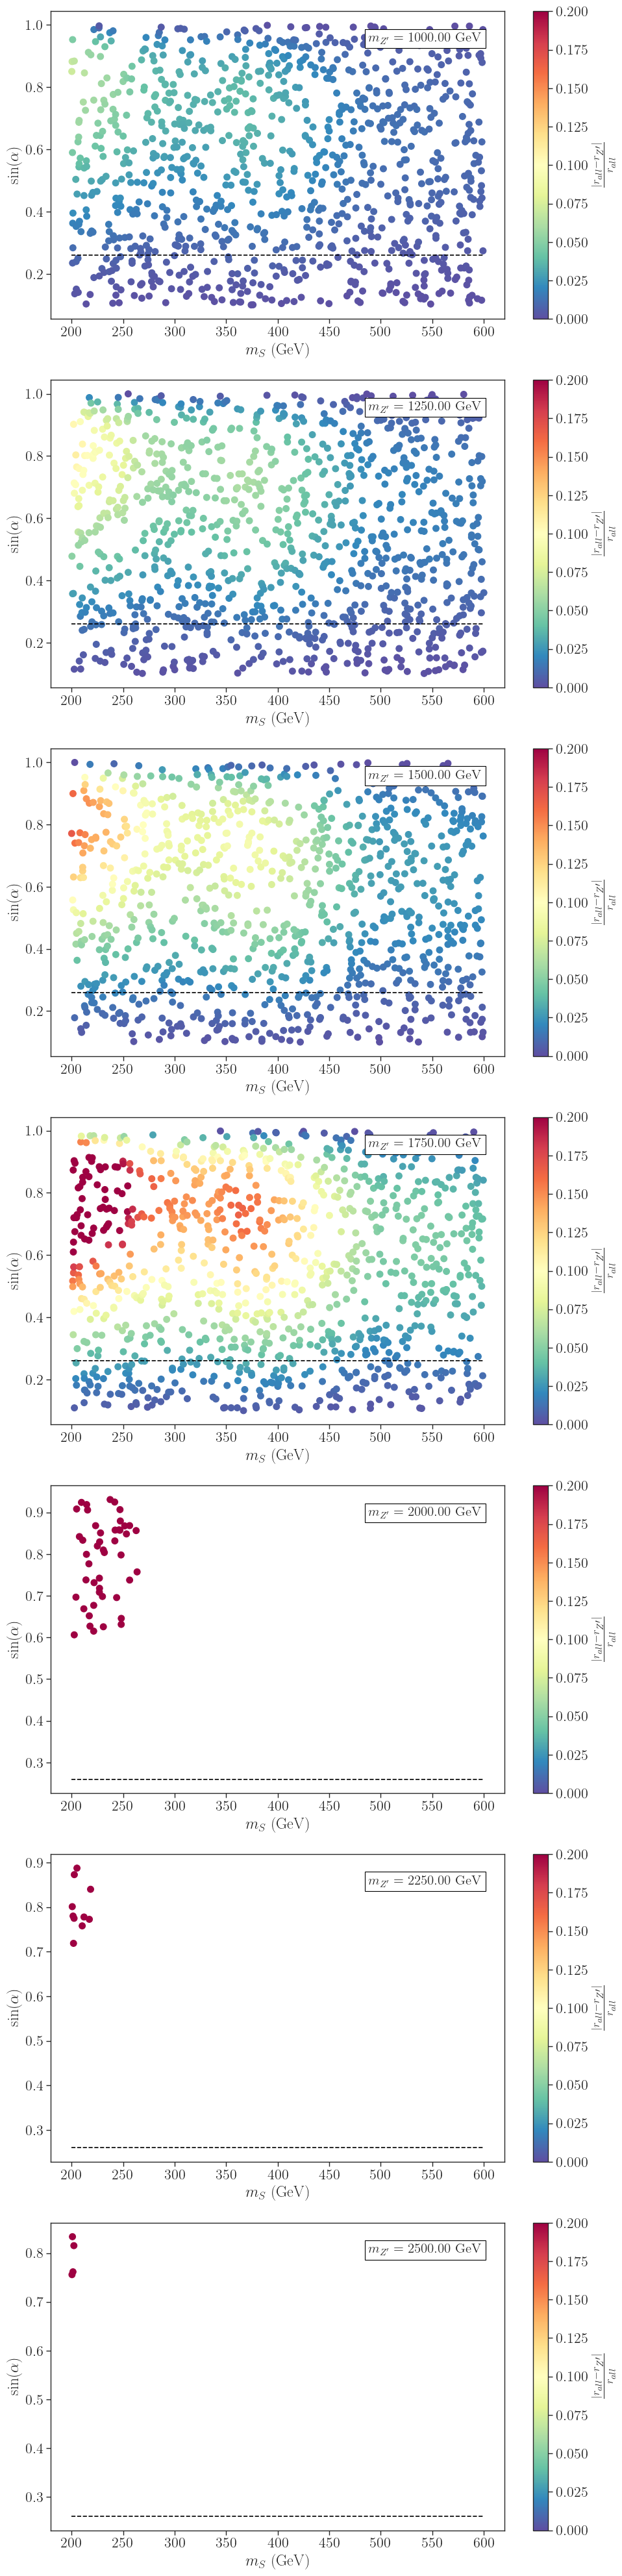

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
fig, ax = plt.subplots(len(zpMasses), figsize=(10,40))

zpMasses.sort()
for i, mzp in enumerate(zpMasses):
    rAll = np.array(dfAll['ExptRes.result.r'][dfAll['mass.9900032']==mzp])
    rZp = np.array(dfZp['ExptRes.result.r'][dfZp['mass.9900032']==mzp])
    rDiff = np.abs(rAll - rZp)/rAll
    
    x = dfAll['mass.9900026'][dfAll['mass.9900032']==mzp]
    y = dfAll['extpar.6'][dfAll['mass.9900032']==mzp]
    c = rDiff
    
    ax[i].hlines(0.26, 200, 600, linestyle='--', color='black')
    
    im = ax[i].scatter(x,y,c=c,s=50,cmap=cm, vmin=0, vmax=0.2)
    plt.colorbar(im, label=r'$\frac{|r_{all} - r_{Z^{\prime}}|}{r_{all}}$', ax=ax[i])
    
    ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
               bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)
    
    ax[i].set_xlabel(r'$m_{S}$ (GeV)')
    ax[i].set_ylabel(r'$\sin(\alpha$)')
    

fig.tight_layout()
plt.show()

In [ ]:
mzp = 1750

In [ ]:
r_diff = np.abs(np.array(dfAll['ExptRes.result.r'][dfAll['mass.9900032']==mzp]) 
                - np.array(dfZp['ExptRes.result.r'][dfZp['mass.9900032']==mzp]))/np.array(dfAll['ExptRes.result.r'][dfAll['mass.9900032']==mzp])

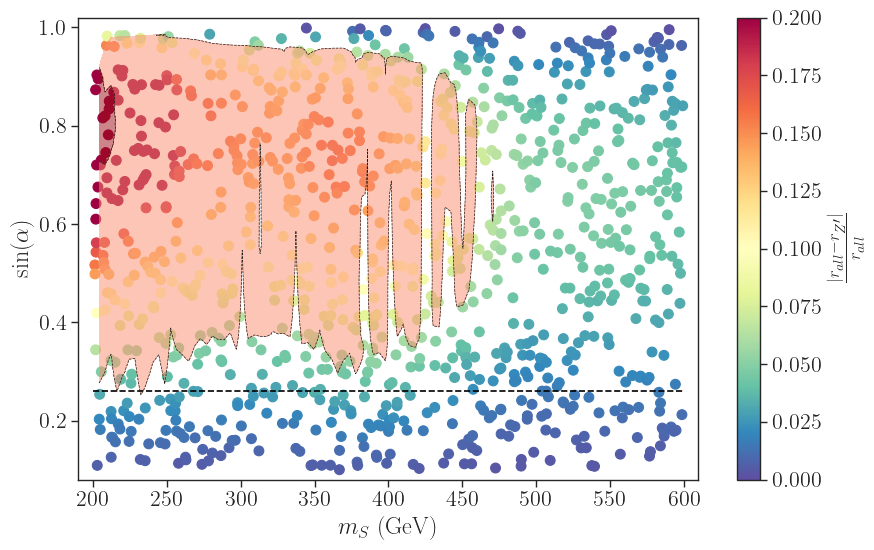

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))

x = dfAll['mass.9900026'][dfAll['mass.9900032']==mzp]
y = dfAll['extpar.6'][dfAll['mass.9900032']==mzp]
c = r_diff

plt.scatter(x,y,c=c,s=50,cmap=cm, vmin=0, vmax=0.2)

plt.colorbar(label=r'$\frac{|r_{all} - r_{Z^{\prime}}|}{r_{all}}$')
plt.hlines(0.26, 200, 600, linestyle='--', color='black')

data = dfAll[dfAll['mass.9900032']==mzp]
rData = data['ExptRes.result.r']
pts = np.array([y for y in product(np.linspace(200,600.,100), np.linspace(0.0,1.0,100))])
rPts = griddata(list(zip(data['mass.9900026'], data['extpar.6'])),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]

cs = plt.tricontour(pts[:,0],pts[:,1],rPts, levels=[0.8, 1.0], colors='k', linewidths=0.5, linestyles='dashed')


plt.tricontourf(pts[:,0],pts[:,1],rPts, levels=[0.8, 1.0, rPts.max()],cmap='Reds', alpha=0.5)



plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

plt.show()

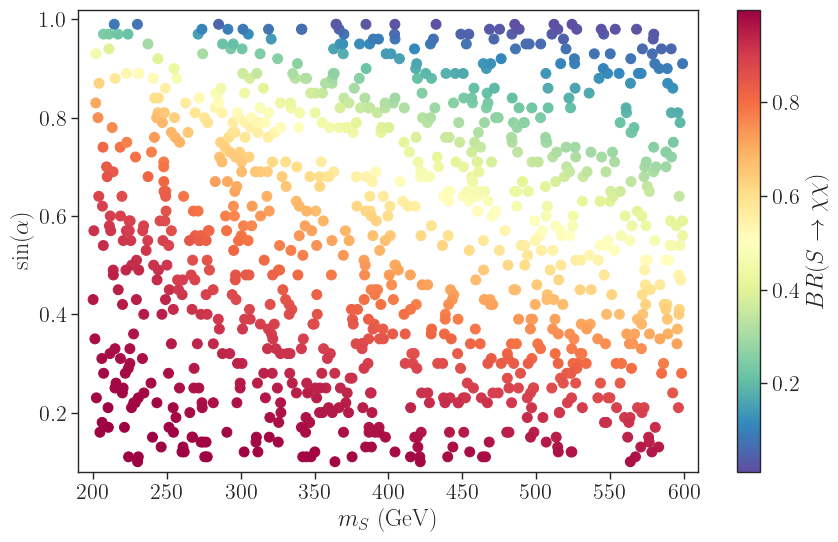

In [ ]:
# Plot scalar BR
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))
mzp = 2000
x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
c = dfSd['BRs.sd.chi,chi'][dfSd['mass.9900032']==mzp]

plt.scatter(x,y,c=c,s=50,cmap=cm)

plt.colorbar(label=r'$BR(S \to \chi \chi)$')

plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

plt.show()

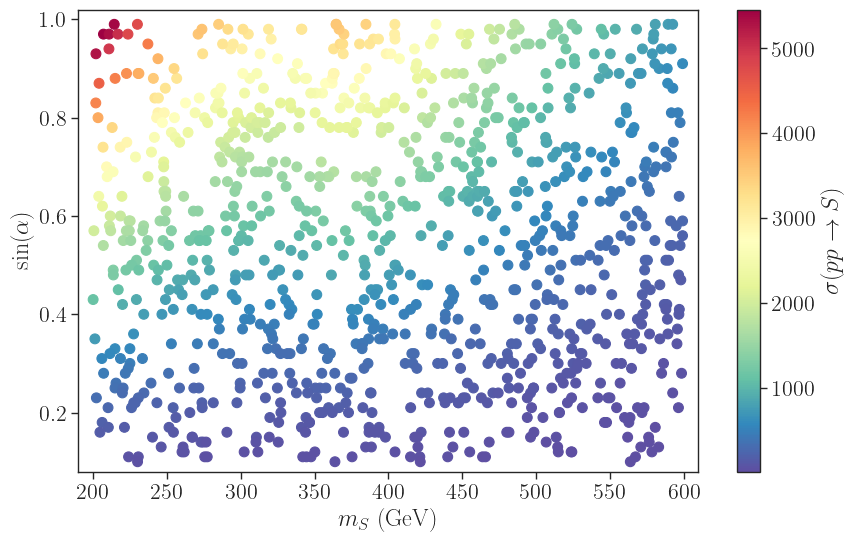

In [ ]:
# plot xsec
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))
mzp = 2000
x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
c = dfSd['xsec13TeV(fb).9900026'][dfSd['mass.9900032']==mzp]

plt.scatter(x,y,c=c,s=50,cmap=cm)

plt.colorbar(label=r'$\sigma(p p \to S)$')

plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

plt.show()

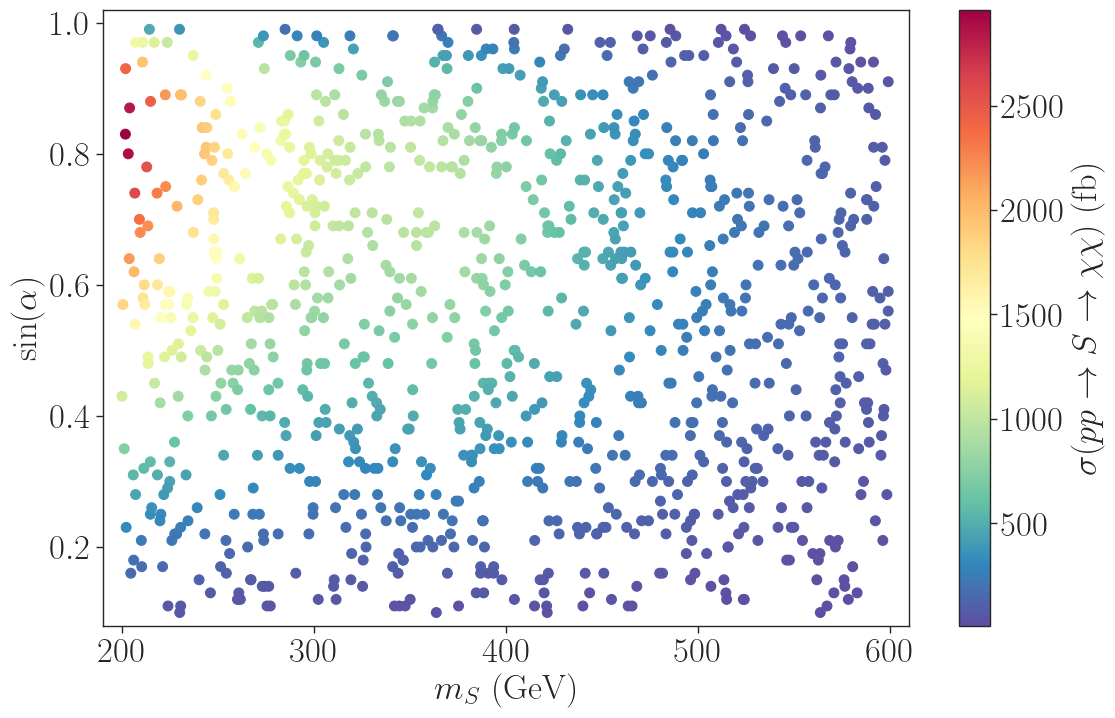

In [ ]:
# plot xsec * br
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(13,8))
mzp = 2000
x = dfSd['mass.9900026'][dfSd['mass.9900032']==mzp]
y = dfSd['extpar.6'][dfSd['mass.9900032']==mzp]
c = dfSd['xsec13TeV(fb).9900026'][dfSd['mass.9900032']==mzp]*dfSd['BRs.sd.chi,chi'][dfSd['mass.9900032']==mzp]

im = plt.scatter(x,y,c=c,s=50,cmap=cm)

cb = plt.colorbar(im)
cb.set_label(label=r'$\sigma(p p \to S \to \chi \chi)$ (fb)', size=25)


plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=25)
plt.ylabel(r'$\sin(\alpha$)', fontsize=25)


im.figure.axes[0].tick_params(axis="both", labelsize=25) 
im.figure.axes[1].tick_params(axis="y", labelsize=25) 

plt.savefig('2mdm-xsection-s.png')
plt.show()

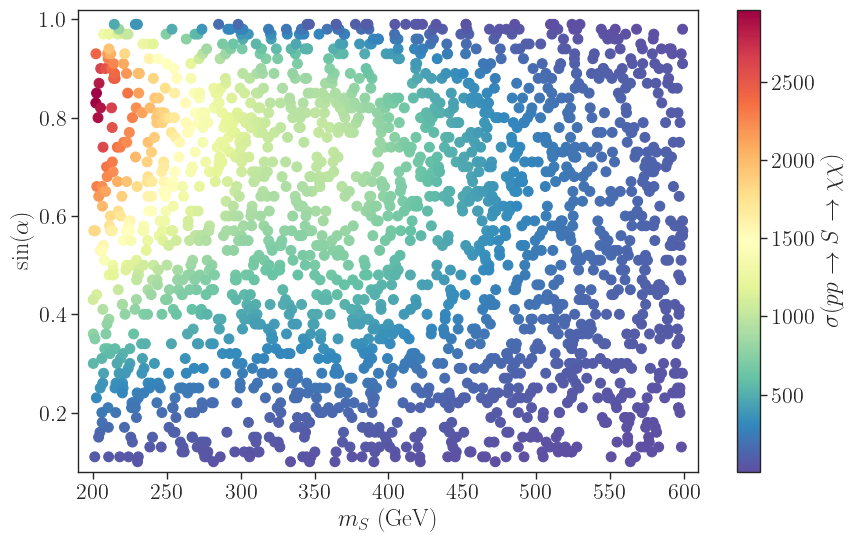

In [ ]:
# plot xsec * br
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(10,6))
x = dfSd['mass.9900026']
y = dfSd['extpar.6']
c = dfSd['xsec13TeV(fb).9900026']*dfSd['BRs.sd.chi,chi']

plt.scatter(x,y,c=c,s=50,cmap=cm)

plt.colorbar(label=r'$\sigma(p p \to S \to \chi \chi)$')

plt.ylim(0.08, 1.02)
plt.xlim(190, 610)
plt.xlabel(r'$m_{S}$ (GeV)')
plt.ylabel(r'$\sin(\alpha$)')

# plt.savefig('2mdm-xsection-s.png')
plt.show()

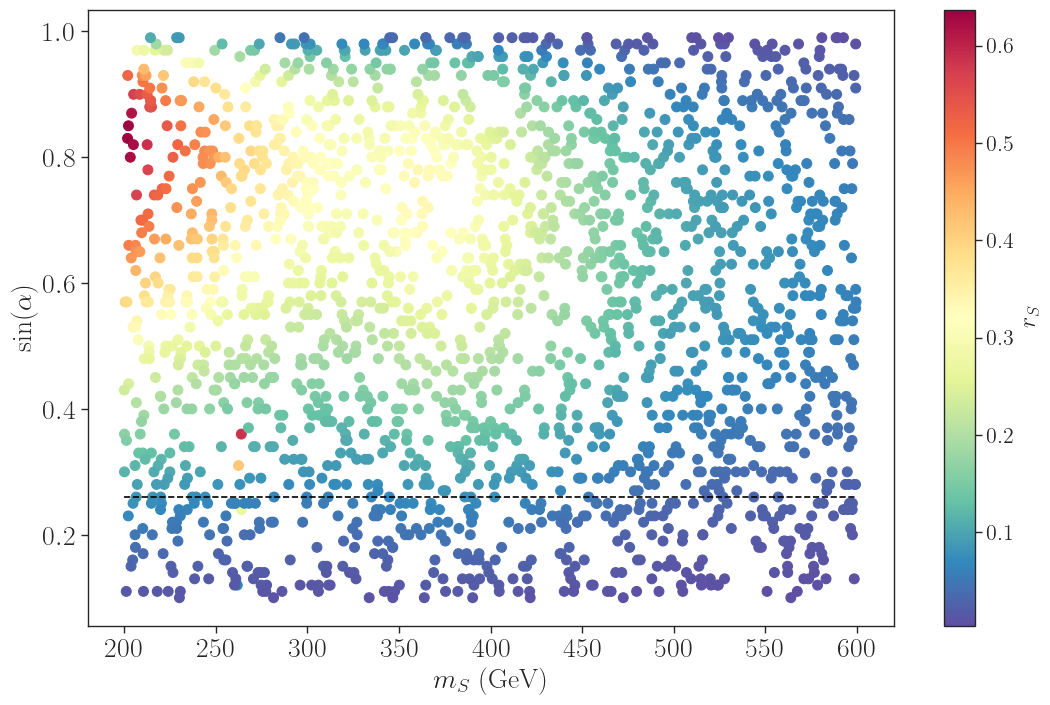

In [ ]:
cm = plt.cm.get_cmap('Spectral_r')
plt.figure(figsize=(13,8))

mzp = 2000.0
x = dfSd['mass.9900026']
y = dfSd['extpar.6']
c = dfSd['ExptRes.result.r']

plt.hlines(0.26, 200, 600, linestyle='--', color='black')

im = plt.scatter(x,y,c=c,s=50,cmap=cm)
plt.colorbar(im, label=r'$r_{S}$')
    
#     ax[i].text(0.7,0.9,r"$m_{Z^{\prime}} = %1.2f$ GeV" %mzp,fontsize=15,
#                bbox=dict(facecolor='white', edgecolor='black'), transform=ax[i].transAxes)
    
plt.xlabel(r'$m_{S}$ (GeV)', fontsize=20)
plt.ylabel(r'$\sin(\alpha$)', fontsize=20)
    
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# plt.savefig('2mdm_rs.png')
fig.tight_layout()
plt.show()

In [ ]:
dfAll['extpar.1']

2369     1.0
53894    1.0
79182    1.0
60995    1.0
53899    1.0
        ... 
58347    1.0
1481     1.0
5511     1.0
33597    1.0
81872    1.0
Name: extpar.1, Length: 4000, dtype: float64

In [ ]:
2.1747*3.423461e-01 + 3.2556*3.053258e-01

1.7385187381499998

In [32]:
mzp = np.random.uniform(200, 4000, 1000)

In [34]:
mchi = np.random.uniform(200, mzp/2, 1000)

In [35]:
mchi

array([ 212.71188889,  613.65854226,  361.20145519,  257.72401367,
       1380.07480911,  238.72488678,  671.45037445, 1109.91534249,
        715.26824868,  413.40529187,  486.43626397,  363.95153093,
        250.52687658,  400.47545156,  315.16698704,  960.24718585,
        326.74215795,  936.65874647,  321.35186586, 1017.97759098,
       1524.81090046,  383.23543982,  361.01315113, 1159.42654073,
        293.97749663,  540.2192844 ,  370.00540586,  258.24065413,
        523.33772308,  238.54849439, 1542.99048645,  363.89073548,
        198.92195484,  259.61889436,  373.79528682,  236.42550865,
       1226.3735382 ,  619.15429452,  192.18244987, 1329.22040079,
        808.53506936,  200.19780203,  699.87258425,  338.00350648,
        495.3153331 , 1532.48005453,  840.7808427 , 1383.27999255,
        217.32725408, 1372.34522515,  651.77381967,  676.69191906,
        360.25897213,  251.1451462 ,  727.26006755,  380.1074493 ,
        315.02043077,  587.97578339,  538.74310365, 1265.53237

In [43]:
for i, m in enumerate(mzp):
    print('('+str(mchi[i])+', '+str(m)+')', end=',')

(212.71188889082592, 926.5810774992235),(613.6585422601296, 2043.162405687314),(361.2014551921616, 3787.5135408512897),(257.7240136706714, 1855.043621912349),(1380.0748091126682, 3857.0172907538927),(238.72488677955425, 1185.9716817146125),(671.4503744543902, 1799.8429503970328),(1109.915342487301, 3411.8230099878874),(715.2682486819505, 3676.5772267492566),(413.4052918663597, 3376.3050188232537),(486.4362639654368, 2833.145994070833),(363.9515309302228, 887.3361643418485),(250.5268765807862, 661.0062481588295),(400.47545156239414, 1023.5898633476392),(315.16698703985855, 1821.8014322067654),(960.2471858531657, 3523.5349162235093),(326.74215795163934, 1472.861451139092),(936.6587464749922, 2404.6536935144545),(321.35186586250836, 3886.656117858173),(1017.977590983509, 3241.0682269573053),(1524.810900462939, 3259.714911682743),(383.2354398206834, 1306.4729550448803),(361.01315112666316, 1153.4049200490854),(1159.4265407262615, 2652.3530301141805),(293.9774966309502, 1167.7322493593272),